In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [2]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:500] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente', 'idadePaciente']]
    
    novo_df = []
    for i in range(len(df)):
        if(df.loc[i][2] == 'Positivo'):
            resultado = 1
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
        else:
            resultado = 0
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
    
    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente', 4: 'idade_paciente'}, inplace=True)    
    return novo_df

In [3]:
df = pre_processamento()
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente,idade_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO,74.0
1,VARJOTA,FORTALEZA,0,FEMININO,31.0
2,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO,84.0
3,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO,61.0
4,PINHEIRO,GUAIÚBA,0,MASCULINO,37.0
...,...,...,...,...,...
495,BURITI,PACAJUS,0,MASCULINO,75.0
496,ALTO DO CRUZEIRO,CHORÓ,0,FEMININO,43.0
497,JABUTI,EUSEBIO,1,MASCULINO,62.0
498,LAMAJU,FARIAS BRITO,0,MASCULINO,36.0


In [4]:
def agrupar_bairros(df):
    bairros = pd.unique(df['bairro_paciente'])
    casos_bairros = []
    for bairro in bairros:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                count = count + 1
        casos_bairros.append([bairro, count])
    casos_bairros = pd.DataFrame(casos_bairros)
    casos_bairros.rename(columns={0: 'bairro', 1: 'count'}, inplace=True)
    return casos_bairros

In [5]:
dataset_bairros = agrupar_bairros(df)

In [6]:
def top_k_reverse_bairros(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output

In [7]:
top_k_reverse_bairros(dataset_bairros, 10)

,bairro,count
0,VILA PERI,1
1,VARJOTA,1
2,NOVA METROPOLE JUREMA,1
3,PARQUE POTIRA JUREMA,1
4,PINHEIRO,1
5,ALDEIA PARK,1
6,PRECABURA,1
7,PL CAUCAIA,1
8,TABAPUA,1
9,ITAPAJE,1


In [8]:
def agrupar_idade(df):
    clusters_idades = []
    intervalos = np.arange(1, 100, dtype=int)
    for i in range(0, 95, 5):
        gaps = []
        for j in range(i, i+5):
            gaps.append(intervalos[j])
        clusters_idades.append(gaps)

    casos_idade = []

    for cluster in clusters_idades:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][4] in cluster):
                count = count + 1
        casos_idade.append(['[{}:{}]'.format(cluster[0], cluster[4]), count])
    casos_idade = pd.DataFrame(casos_idade)
    casos_idade.rename(columns={0: 'idade', 1: 'count'}, inplace=True)
    casos_idade = casos_idade.sort_values(by=['count'], ascending=True)
    ordem = np.arange(1,len(casos_idade)+1)
    casos_idade['ordem'] = pd.Series(ordem, index=casos_idade.index)
    return casos_idade

In [9]:
dataset_idade = agrupar_idade(df)
dataset_idade

,idade,count,ordem
1,[6:10],2,1
0,[1:5],5,2
17,[86:90],6,3
18,[91:95],6,4
2,[11:15],7,5
16,[81:85],12,6
3,[16:20],12,7
13,[66:70],13,8
15,[76:80],15,9
11,[56:60],20,10


In [10]:
def top_k_reverse_idade(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output

In [11]:
#Aproveitando q ordenei
#def top_k_reverse_idade(dataset, k):
#    output = []
#    for i in range(k):
#        output.append([dataset.loc[k][0], dataset.loc[k][1]])
#    output = pd.DataFrame(output)
#    output = output.rename(columns={0: 'idade', 1: 'count'})
#    return output

In [12]:
top_k_reverse_idade(dataset_idade, 10)

,idade,count
0,[6:10],2
1,[1:5],5
2,[86:90],6
3,[91:95],6
4,[11:15],7
5,[81:85],12
6,[16:20],12
7,[66:70],13
8,[76:80],15
9,[56:60],20


# Ruído de Laplace

In [13]:
def sensibilidade_lap(dataset):
    return 1

In [14]:
def erros_lap(query, argumento_consulta, k):
    erros_laplace = []
    top = list(query)
    for argumento in argumento_consulta:
        erro_argumento_lap = [0]*10
        for i in range(len(argumento)):
            if(argumento[i] == top[i]):
                erro = 0
            else:
                erro = abs(top.index(argumento[i]) - i)
            erro_argumento_lap[i]  = erro
        erros_laplace.append(erro_argumento_lap)
    return erros_laplace

In [15]:
def plot_erros(erros_argumento, k):
    df = pd.DataFrame({
        'epsilon': ['0.1', '1', '10'],
        'erro': erros_argumento,
        'k = %i'%(k): k})
    return df.plot(kind='bar', x='epsilon')

# Consulta Bairros com Ruído

In [16]:
def laplace_bairros(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_bairros = np.array(query['bairro'])
    output = []
    np.random.seed(123)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'bairro': coluna_bairros,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['bairro', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [17]:
budgets = [0.1, 1, 10]
k = 10
bairros = []
for budget in budgets:
    a = laplace_bairros(budget, sensibilidade_lap(dataset_bairros), top_k_reverse_bairros(dataset_bairros, k), dataset_bairros, k)
    a = np.array(a)
    print("epsilon: {}\nreverse top-{}:\n{}\n\n".format(budget, k, a))
    bairros.append(a[:,0])

epsilon: 0.1
reverse top-10:
[['NOVA METROPOLE JUREMA' -6.9031268473211655]
 ['VARJOTA' -4.581292210973028]
 ['ITAPAJE' -1.4304651224855673]
 ['ALDEIA PARK' -0.669842722604737]
 ['TABAPUA' 0.6111758470501567]
 ['PARQUE POTIRA JUREMA' 2.082865012547421]
 ['PL CAUCAIA' 5.6149509319177975]
 ['VILA PERI' 5.991249629211602]
 ['PINHEIRO' 6.779237549274969]
 ['PRECABURA' 33.57834888254776]]


epsilon: 1
reverse top-10:
[['NOVA METROPOLE JUREMA' 0.20968731526788342]
 ['VARJOTA' 0.4418707789026972]
 ['ITAPAJE' 0.7569534877514432]
 ['ALDEIA PARK' 0.8330157277395263]
 ['TABAPUA' 0.9611175847050156]
 ['PARQUE POTIRA JUREMA' 1.108286501254742]
 ['PL CAUCAIA' 1.4614950931917798]
 ['VILA PERI' 1.4991249629211603]
 ['PINHEIRO' 1.577923754927497]
 ['PRECABURA' 4.257834888254775]]


epsilon: 10
reverse top-10:
[['NOVA METROPOLE JUREMA' 0.9209687315267884]
 ['VARJOTA' 0.9441870778902697]
 ['ITAPAJE' 0.9756953487751443]
 ['ALDEIA PARK' 0.9833015727739526]
 ['TABAPUA' 0.9961117584705016]
 ['PARQUE POTIRA J

In [18]:
#inverti linha/coluna pra fazer a acumulada dos k pra plotar pra cada k
erros_bairro = erros_lap(top_k_reverse_bairros(dataset_bairros, 10)['bairro'], bairros, 10)
lista_plot = []
for i in range(k):
    p_cada_k = []
    for b in range(len(budgets)):
        aux = erros_bairro[b][i]
        p_cada_k.append(aux)
    lista_plot.append(p_cada_k)
print(erros_bairro)

[[2, 0, 7, 2, 4, 2, 1, 7, 4, 3], [2, 0, 7, 2, 4, 2, 1, 7, 4, 3], [2, 0, 7, 2, 4, 2, 1, 7, 4, 3]]


In [19]:
copia = lista_plot.copy()
aux = []
aux.append(copia[0])
for i in range(1, k):
    copia[i][0] += copia[i-1][0] 
    copia[i][1] += copia[i-1][1] 
    copia[i][2] += copia[i-1][2]
    aux.append([copia[i][0], copia[i][1], copia[i][2]])

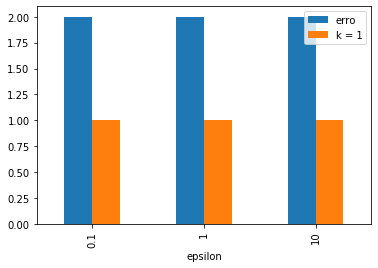

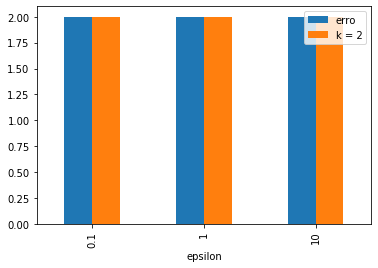

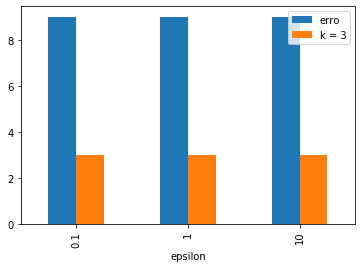

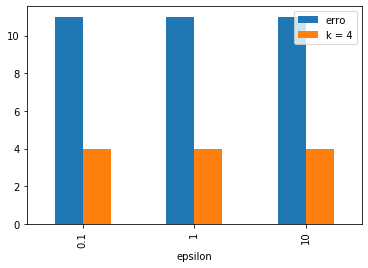

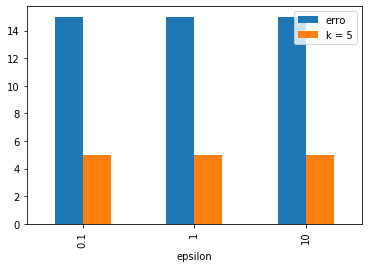

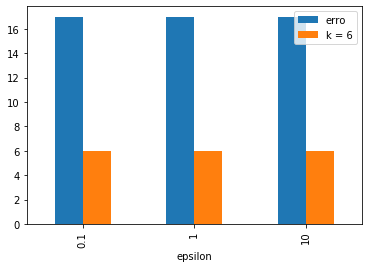

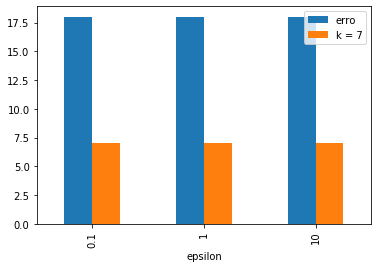

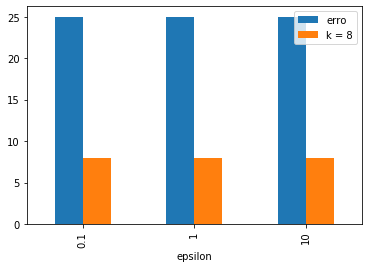

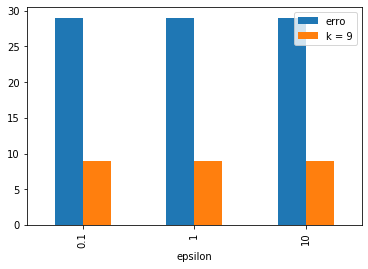

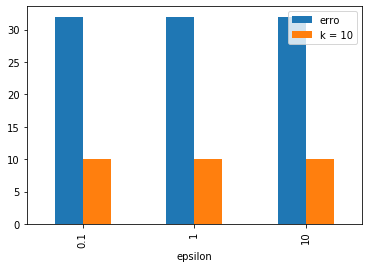

In [20]:
for i in range(0, k):
    plot_erros(aux[i], i+1)

# Consulta Idade com ruído

In [21]:
def laplace_idade(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_idades = np.array(query['idade'])
    output = []
    np.random.seed(123)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'idade': coluna_idades,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['idade', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [22]:
budgets = [0.1, 1, 10]
idades = []
k = 10
for budget in budgets:
    a = laplace_idade(budget, sensibilidade_lap(dataset_idade), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10)
    a = np.array(a)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, a))
    idades.append(a[:,0])

epsilon: 0.1
reverse top-k:
[['[86:90]' -1.9031268473211655]
 ['[1:5]' -0.5812922109730279]
 ['[6:10]' 6.991249629211602]
 ['[91:95]' 7.082865012547421]
 ['[81:85]' 10.330157277395262]
 ['[11:15]' 12.779237549274969]
 ['[76:80]' 14.611175847050157]
 ['[56:60]' 17.56953487751443]
 ['[66:70]' 17.614950931917797]
 ['[16:20]' 44.57834888254776]]


epsilon: 1
reverse top-k:
[['[6:10]' 2.4991249629211603]
 ['[1:5]' 4.441870778902697]
 ['[86:90]' 5.2096873152678835]
 ['[91:95]' 6.108286501254742]
 ['[11:15]' 7.577923754927497]
 ['[81:85]' 11.833015727739527]
 ['[66:70]' 13.461495093191779]
 ['[76:80]' 14.961117584705015]
 ['[16:20]' 15.257834888254775]
 ['[56:60]' 19.756953487751442]]


epsilon: 10
reverse top-k:
[['[6:10]' 2.049912496292116]
 ['[1:5]' 4.94418707789027]
 ['[86:90]' 5.920968731526789]
 ['[91:95]' 6.010828650125474]
 ['[11:15]' 7.05779237549275]
 ['[81:85]' 11.983301572773952]
 ['[16:20]' 12.325783488825477]
 ['[66:70]' 13.046149509319179]
 ['[76:80]' 14.996111758470501]
 ['[56

In [23]:
query_idades = top_k_reverse_idade(dataset_idade, 10)['idade']
erros_idade = erros_lap(query_idades, idades, 10)
lista_plot_idades = []
for i in range(k):
    p_cada_k = []
    for b in range(len(budgets)):
        aux = erros_idade[b][i]
        p_cada_k.append(aux)
    lista_plot_idades.append(p_cada_k)

In [24]:
copia_idades = lista_plot_idades.copy()
aux_idades = []
aux_idades.append(copia_idades[0])
for i in range(1, k):
    copia_idades[i][0] += copia_idades[i-1][0] 
    copia_idades[i][1] += copia_idades[i-1][1] 
    copia_idades[i][2] += copia_idades[i-1][2]
    aux_idades.append([copia_idades[i][0], copia_idades[i][1], copia_idades[i][2]])
aux_idades

[[2, 0, 0],
 [2, 0, 0],
 [4, 0, 0],
 [4, 0, 0],
 [5, 0, 0],
 [6, 0, 0],
 [8, 1, 0],
 [10, 2, 0],
 [11, 4, 0],
 [14, 4, 0]]

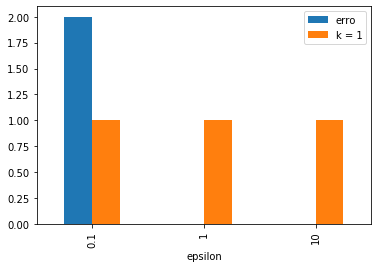

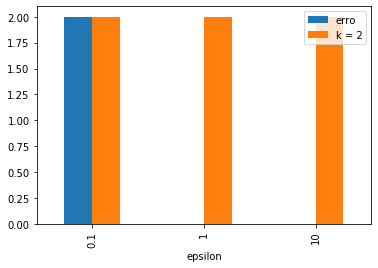

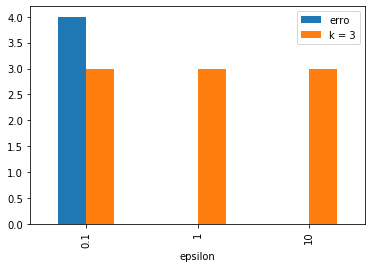

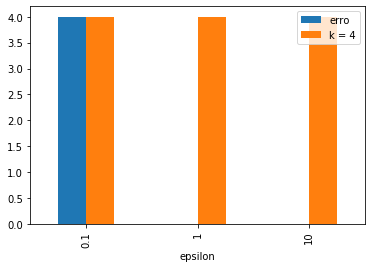

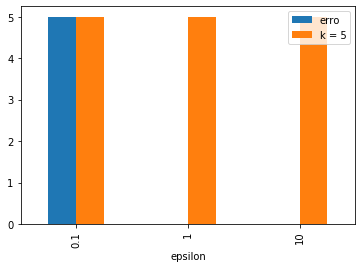

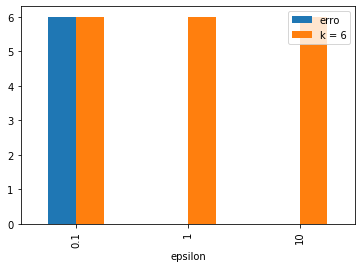

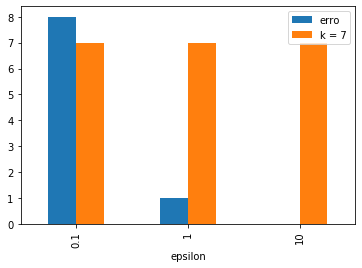

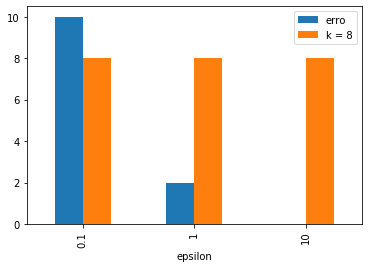

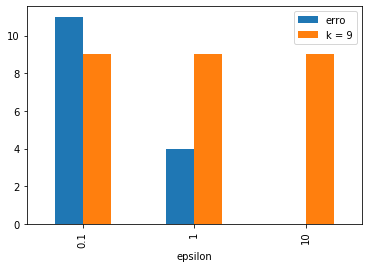

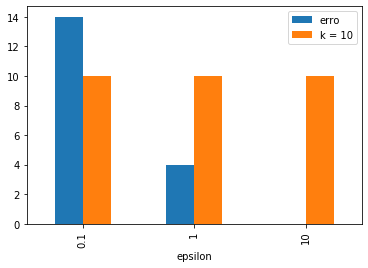

In [25]:
for i in range(0, k):
    plot_erros(aux_idades[i], i+1)

# Mecanismo Exponencial

In [26]:
def score_function_exp(dataset):
    return -dataset['ordem']

In [27]:
def sensibilidade_exp(dataset):
    return 1

In [28]:
def erros_exp(query, argumento_consulta, k):
    erros_exponencial = []
    top = list(query)
    for argumento in argumento_consulta:
        erro_argumento_exp = [0]*10
        for i in range(len(argumento)):
            if(argumento[i] in top):
                if(argumento[i] == top[i]):
                    erro = 0
                else:
                    erro = abs(top.index(argumento[i]) - i)
            else:
                erro = 20
            erro_argumento_exp[i]  = erro
        erros_exponencial.append(erro_argumento_exp)
    return erros_exponencial

# Consulta Idade Exponencial

In [29]:
def exp_idades(budget, sensibilidade, dataset, k):
    budget = budget/k
    
    scores = score_function_exp(dataset)
    x = np.arange(len(scores))
    probabilidades = []
    
    for score in scores:
        probabilidade = math.exp((budget * score)/(2 * sensibilidade))
        probabilidades.append(probabilidade)
        
    probabilidades = [prob/sum(probabilidades) for prob in probabilidades]    
    dist = stats.rv_discrete(name='dist', values=(x, probabilidades))    
    output = []
    
    for i in range(k):
        valido = False
        while(not valido):
            indice = dist.rvs()
            if([dataset_idade.loc[indice][0], -scores[indice]] not in output):
                output.append([dataset.loc[indice][0], -scores[indice]])
                valido = True
                
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output.sort_values(by=['count'], ascending=True)

In [30]:
budgets = [0.1, 1, 10]
idades_exp = []

for budget in budgets:
    b = exp_idades(budget, sensibilidade_exp(dataset_idade), dataset_idade, 10)
    b = np.array(b)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, b))
    idades_exp.append(b[:,0])

epsilon: 0.1
reverse top-k:
[['[6:10]' 1]
 ['[81:85]' 6]
 ['[16:20]' 7]
 ['[66:70]' 8]
 ['[56:60]' 10]
 ['[46:50]' 14]
 ['[31:35]' 16]
 ['[41:45]' 17]
 ['[26:30]' 18]
 ['[36:40]' 19]]


epsilon: 1
reverse top-k:
[['[6:10]' 1]
 ['[86:90]' 3]
 ['[91:95]' 4]
 ['[16:20]' 7]
 ['[76:80]' 9]
 ['[46:50]' 14]
 ['[21:25]' 15]
 ['[31:35]' 16]
 ['[26:30]' 18]
 ['[36:40]' 19]]


epsilon: 10
reverse top-k:
[['[6:10]' 1]
 ['[1:5]' 2]
 ['[11:15]' 5]
 ['[16:20]' 7]
 ['[56:60]' 10]
 ['[51:55]' 13]
 ['[46:50]' 14]
 ['[21:25]' 15]
 ['[41:45]' 17]
 ['[26:30]' 18]]




In [31]:
query_idades_exp = top_k_reverse_idade(dataset_idade, 10)['idade']
erros_idade_exp = erros_exp(query_idades_exp, idades_exp, 10)
exp_plot_idades = []
for i in range(k):
    p_cada_k = []
    for b in range(len(budgets)):
        aux = erros_idade_exp[b][i]
        p_cada_k.append(aux)
    exp_plot_idades.append(p_cada_k)

In [32]:
copia_idades_exp = exp_plot_idades.copy()
aux_idades_exp = []
aux_idades_exp.append(copia_idades_exp[0])
for i in range(1, k):
    copia_idades_exp[i][0] += copia_idades_exp[i-1][0] 
    copia_idades_exp[i][1] += copia_idades_exp[i-1][1] 
    copia_idades_exp[i][2] += copia_idades_exp[i-1][2]
    aux_idades_exp.append([copia_idades_exp[i][0], copia_idades_exp[i][1], copia_idades_exp[i][2]])
aux_idades_exp

[[0, 0, 0],
 [4, 1, 0],
 [8, 2, 2],
 [12, 5, 5],
 [17, 9, 10],
 [37, 29, 30],
 [57, 49, 50],
 [77, 69, 70],
 [97, 89, 90],
 [117, 109, 110]]

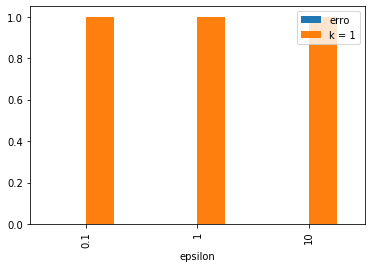

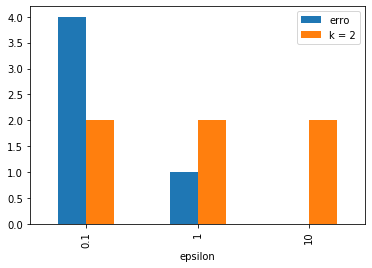

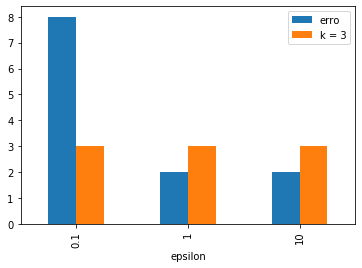

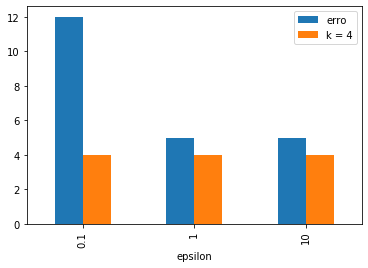

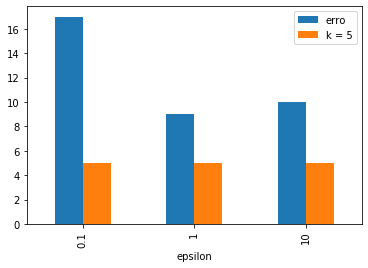

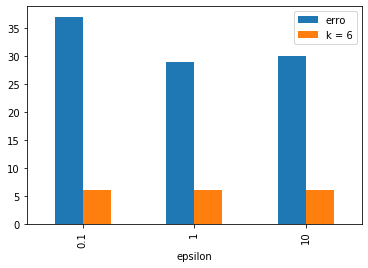

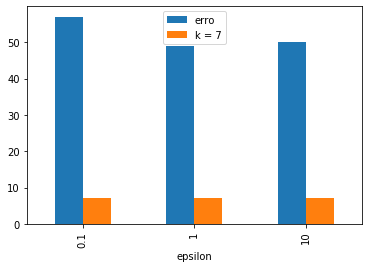

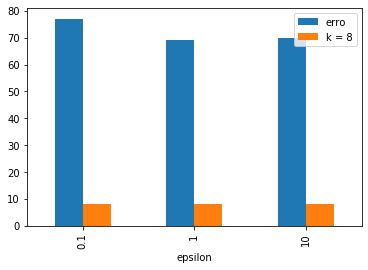

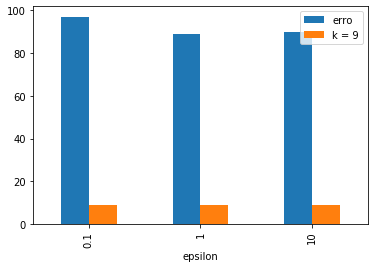

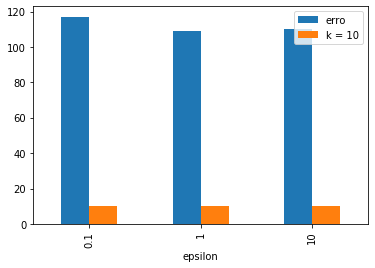

In [33]:
for i in range(0, k):
    plot_erros(aux_idades_exp[i], i+1)